In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [33]:
def read_files(directory='../data/data/'):
    return [files for files in os.listdir(directory)]

def last_observed_benchmark(filenames, start, end):
    '''
    For a given start and end index iterate through dataframes to fetch the latest item
    and return it as prediction for that range
    '''
    predictions = []
    for i in range(start, end):
        df = pd.read_csv('../data/data/'+ str(i) + '.csv')
        recent_observation = df.iloc[-1:, 0:198]
        predictions.append(recent_observation)
    
    recent_observations_df = pd.concat(predictions, axis=0)
    recent_observations_df = recent_observations_df.set_index(np.arange(start - 1, end - 1))
    
    return recent_observations_df

def loss(y, y_pred):
    e = abs(y - y_pred)
    return e

In [24]:
filenames = read_files()
recent_observation_df = last_observed_benchmark(filenames, 1, 201)

In [31]:
## load true values
trueLabels = pd.read_csv('../data/trainLabels.csv')
y_true = trueLabels.iloc[:, 1:]

In [34]:
## lets take a look at the loss metric
e = loss(y_true, recent_observation_df)

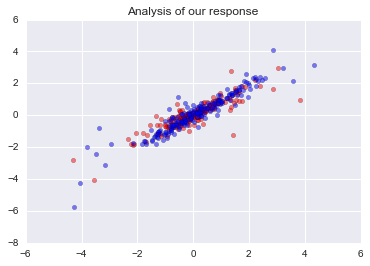

In [38]:
plt.scatter(y_true.iloc[:, 5], recent_observation_df.iloc[:, 5], c='r', alpha=.5)
plt.scatter(y_true.iloc[:, 6], recent_observation_df.iloc[:, 6], c='b', alpha=.5)
plt.title('Analysis of our response');

In [40]:
print 'Error on the training set is %f ' %e.mean(axis=1).mean()

Error on the training set is 0.440612 


## Visulization of the Price Movements

In [71]:
def concatenate_intra_day_results():
    """
    Concatenate intra day results for all the securities
    """
    predictions = []
    for i in range(1, 511):
        df = pd.read_csv('../data/data/'+ str(i) + '.csv')
        predictions.append(df)
    
    merged_df = pd.concat(predictions, axis=0)
    return merged_df

merged_df = concatenate_intra_day_results()

In [77]:
merged_df = merged_df.set_index(np.arange(0, 55 * 510))

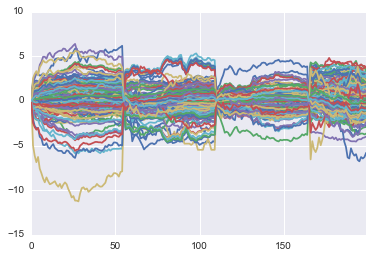

In [90]:
merged_df.iloc[: 200, :198].plot(legend=False);

### How does error varies if we vary how many days we take into account ?

In [125]:
def error_variation(dfs, y_true, func, days_to_consider=10):
    """
    Takes in range of days that we should consider for prediction
    Last Observed is a special case with num_days = 1
    """
    recent_observations = []
    errors = []
    
    for i in range(1, days_to_consider):
        recent_observations = []
        for j in range(len(dfs)):
            df = dfs[j]
            observation = df.iloc[(-1*i):, 0:198].apply(func, axis=0)
            recent_observations.append(observation)
        
        recent_obs_df = pd.concat(recent_observations, axis=1)
        recent_obs_df = recent_obs_df.T
        e = abs(y_true - recent_obs_df)
        errors.append(e.mean(axis=1).mean())
    
    return errors

def create_training_set():
    training_dfs = []
    for i in range(1, 201):
        training_dfs.append(pd.read_csv('../data/data/' + str(i) + '.csv'))
    
    return training_dfs

training_dfs = create_training_set()
errors_mean = error_variation(training_dfs, y_true, np.mean)
errors_median = error_variation(training_dfs, y_true, np.median)

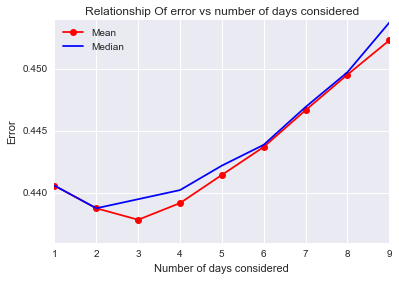

In [129]:
plt.plot(np.arange(1, 10), errors_mean, label='Mean', c='r', marker='o')
plt.plot(np.arange(1, 10), errors_median, label='Median', c='b')
plt.xlabel('Number of days considered')
plt.ylabel('Error')
plt.title('Relationship Of error vs number of days considered')
plt.legend(loc='best');

In [132]:
def create_test_set():
    test_dfs = []
    for i in range(201, 511):
        test_dfs.append(pd.read_csv('../data/data/' + str(i) + '.csv'))
    
    return test_dfs

def get_prediction_df(dfs, days_to_consider=3):
    recent_observations = []
    for j in range(len(dfs)):
        df = dfs[j]
        observation = df.iloc[(-1*days_to_consider):, 0:198].apply(np.mean, axis=0)
        recent_observations.append(observation)

    recent_obs_df = pd.concat(recent_observations, axis=1)
    recent_obs_df = recent_obs_df.T
    
    return recent_obs_df


test_dfs = create_test_set()
prediction_matrix = get_prediction_df(test_dfs)

## Submission

In [133]:
recent_observation_df_test = prediction_matrix.set_index(np.arange(0, 310))

In [136]:
submission = pd.read_csv('../data/sampleSubmission.csv')

In [137]:
submission.iloc[:, 1:] = recent_observation_df_test

In [139]:
submission.to_csv('../submissions/consider_3_days_worth_data.csv', index=False)